# Neural Nets, Stock Prices, and the Fourier Transform


Stock prices are notoriously difficult to forecast. There are various reasons for this, depending on how you approach the problem. These reasons include (but are not limited to) self-similarity, non-periodicity, and the chaotic nature of price movements. But no matter the underlying reasons, one thing remains certain: typical methods, such as ARIMA and the many flavors of RNNs, have proved unreliable at solving this task.

In this article, we're going to explore a slightly unconventional way of forecasting stock prices. And to do that, we're going to view prices as a waveform.

Representing price as a waveform implies some underlying assumptions; the most important being that price is really just a composite signal made up of a number of sinusoids. To both identify and analyze these constituent sinusoids, we can use the Discrete Fourier Transform (DFT) to decompose our signal. Likewise, we can also use the inverse Discrete Fourier Transform (iDFT) to reconstruct our original signal from these underlying parts.
For those who don't know, the DFT allows you to translate a signal from the time domain into the frequency domain. And the iDFT does the reverse; meaning it allows you to translate from the frequency domain back into the time domain. For a mathematical definition please see https://en.wikipedia.org/wiki/Discrete_Fourier_transform or https://www.allaboutcircuits.com/technical-articles/an-introduction-to-the-discrete-fourier-transform/

To demonstrate this principle, imagine a musician playing an (angsty) A-Minor chord on the piano. Using the DFT, we can decompose this chord into its constituent parts, namely the notes "A", "C", and "E". This can be shown below.

In [1]:
from typing import *
import math
import numpy as np
import pandas as pd
import scipy.fft
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

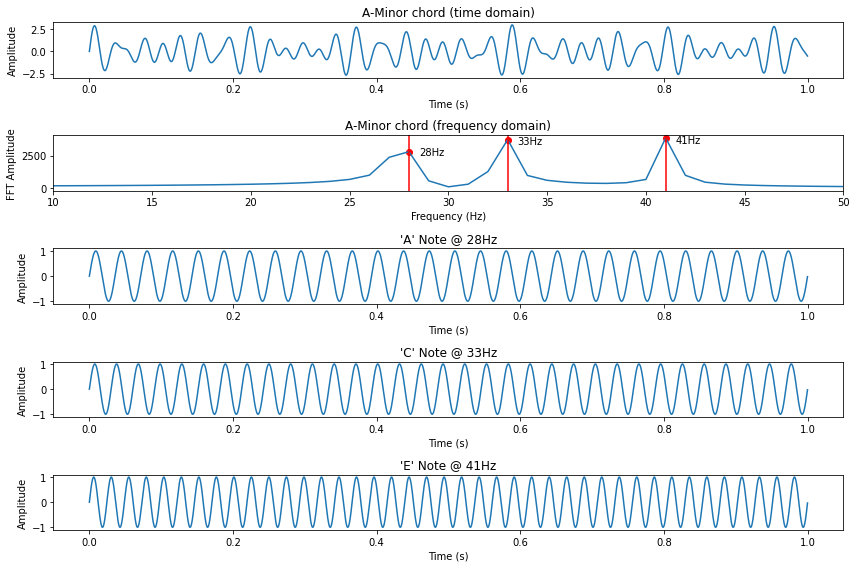

In [2]:

#frequencies of a, c, e -- the notes that make up an a-minor chord
a_minor = {"a": 27.59, "c": 32.70, "e": 41.20} 

#we set the sample rate equal to the least common multiple of the fractional portion of the frequencies
sample_rate = math.lcm(59, 70, 20)
x = np.linspace(0, 1, sample_rate, endpoint=False)
#a chord is the sum of of individual notes
chord = [] 
for note, freq in a_minor.items():
    y = np.sin(2 * np.pi * freq * x)
    chord.append(y)
chord = np.sum(chord, axis=0)

plt.figure(figsize=(12,8))
plt.subplot(5, 1, 1)
plt.plot(x, chord)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title("A-Minor chord (time domain)")


#use the fast fourier transform to translate into the frequency domain
fft = scipy.fft.rfft(chord)
fft_abs = np.abs(fft)
fft_freq = scipy.fft.rfftfreq(sample_rate, 1/sample_rate)

#index of peaks --- should roughly correlate to the whole number part of note frequencies 
peaks = find_peaks(fft_abs)[0] 

plt.subplot(5, 1, 2)
plt.plot(fft_freq, fft_abs)
plt.xlim(10, 50)
plt.ylabel('FFT Amplitude')
plt.xlabel('Frequency (Hz)')
plt.scatter(peaks, fft_abs[peaks], c="red")
for peak in peaks:
    plt.axvline(peak, c="red")
    plt.text(peak+0.5,fft_abs[peak]*0.9, f"{peak}Hz")
plt.title("A-Minor chord (frequency domain)")


#for simplicity, round our frequencies and reverse keys/values to query this dictionary by freq
a_minor_whole = dict([(round(freq), note) for note, freq in a_minor.items()])

for i, freq in enumerate(peaks):
    x = np.linspace(0, 1, sample_rate, endpoint=False)
    y = np.sin(2 * np.pi * freq * x)
    plt.subplot(5, 1, i+3)
    plt.plot(x,y)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.title(f"'{a_minor_whole[freq].upper()}' Note @ {freq}Hz")

plt.tight_layout()
plt.show()


Let's break down what we just did there. First (from top to bottom), we started off by plotting an A-Minor chord. Next, we used the DFT to translate the A-Minor chord from the time domain into the frequency domain. 

Lastly, once in the frequency domain, we found the frequencies with the most prominent amplitudes, which gave us 28Hz, 33Hz, and 41Hz. Note that these are the frequencies associated with the notes that made up our A-Minor chord: "A", "C", and "E", respectively.

So we were able to use the DFT to break down the original chord into its constituent notes. Likewise, now that we have our three notes ("A", "C", and "E"), we can use the iDFT to reconstruct our original A-Minor chord. Here is the result of that below:


Root Mean Sqaure Error Between Original and Reconstructed: 5.728207091862298e-16


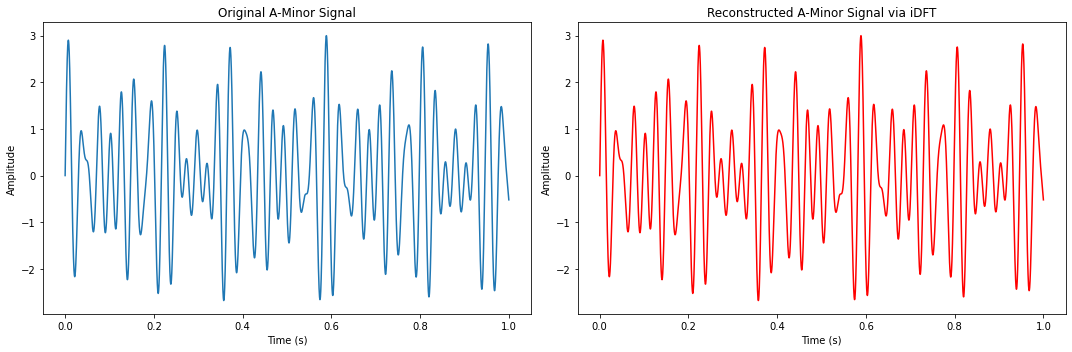

In [3]:
def mse(y: np.ndarray, yhat: np.ndarray) -> float:
    return np.square(np.subtract(y, yhat)).mean()

def rmse(y: np.ndarray, yhat: np.ndarray) -> float:
    return np.sqrt(mse(y, yhat))

#reconstruct original chord using inverse DFt
reconstructed = scipy.fft.irfft(fft)

print(f"Root Mean Sqaure Error Between Original and Reconstructed: {rmse(chord, reconstructed)}")


plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(x, chord)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("Original A-Minor Signal")

plt.subplot(122)
plt.plot(x, reconstructed, c="red")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("Reconstructed A-Minor Signal via iDFT")
plt.tight_layout()
plt.show()



As you can see, the reconstructed signal matches the original signal (almost) perfectly. The extremely small error (5.7e-16) proves this quantitatively.

So we know the DFT is capable of interpolation. But as cool as that is, what about extrapolation? Can we use the DFT and iDFT to effectively forecast a signal into the future?

Turns out, the answer is yes - however, with some strings attached.

To extrapolate a signal, we can calculate the DFT for N timesteps, find the frequencies of the "x" most prominent amplitudes, and then use the iDFT to reconstruct our series over N+p (where p is equal to the number of future timesteps we want to predict). Doing this yields the below, where the red line is our prediction based on the iDFT:



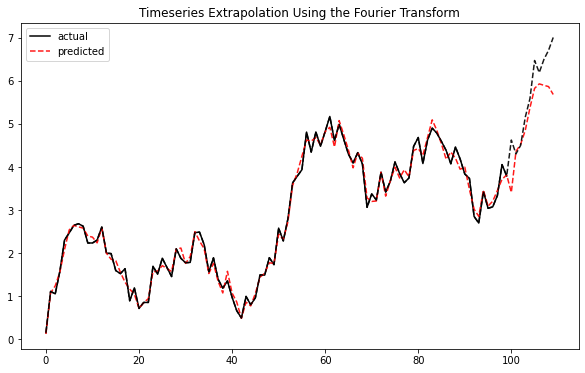

In [4]:
def extrapolate_fourier(y: np.ndarray, 
                        num_steps: int, 
                        num_harmonics: int = 10) -> np.ndarray:
    """
    ---------
    Extrapolate Timeseries using Fourier Transform
    ---------
    PARAMS
    ---------
        1. 'x' -> data values
        2. 'num_steps' -> How many timesteps ahead to predict
        3. 'num_harmonics' -> Number of harmonics to consider
    ---------
    Adapted from:
        https://gist.github.com/tartakynov/83f3cd8f44208a1856ce
    ---------
    """
    n = y.size #num samples
    x = np.arange(n)
    m, _ = np.polyfit(x, y, 1) #m,b of y
    y = y - m * x # detrend y
    x_fdomain = scipy.fft.fft(y) # translate to frequency domain
    f = scipy.fft.fftfreq(n) #freqs 
    idxs = list(x)
    #we want the amplitude peaks -- so we sort idxs by amplitude, descending order
    idxs.sort(key=lambda i: np.absolute(x_fdomain[i])) 
    idxs.reverse()
    x = np.arange(n + num_steps)
    yhat = np.zeros(x.size)
    for i in idxs[:1 + num_harmonics*2]:
        amp = np.absolute(x_fdomain[i]) / n 
        phase = np.angle(x_fdomain[i]) 
        yhat += amp * np.cos(2 * np.pi * f[i] * x + phase)
    return yhat + m * x
        

x = np.linspace(0, 1, 110)
y = np.sin(4.25*np.pi*x) + np.sin(8.5*np.pi*x) + 5*x + np.random.uniform(size=110)

y_new = y[-10:]
y = y[:-10]
yhat = extrapolate_fourier(y, num_steps=10, num_harmonics=20)

plt.figure(figsize=(10,6))
plt.plot(y, c="black", label="actual")
plt.plot(yhat, linestyle="--", c="red", alpha=0.9, label="predicted")
plt.plot(np.concatenate([y, y_new]), c="black", linestyle="--", alpha=0.9)
plt.legend()
plt.title("Timeseries Extrapolation Using the Fourier Transform")
plt.show()


The results actually aren't half bad (for our toy dataset, that is). Unfortunately, as you will see, there are many inherent issues with this method when using real-world, non-periodic data. For now though, let's demonstrate this on stock prices.

First, we will reiterate that the iDFT is indeed able to reconstruct any signal almost perfectly.

In [5]:
from __future__ import annotations
import os 

class Prices:
    def __init__(self, vals: np.ndarray):
        self.vals = vals
    
    def __len__(self):
        return len(self.vals)
    
    @classmethod
    def from_csv(self, filepath: str, column_name: str) -> Prices:
        assert os.path.exists(filepath), f"{filepath} does not exist."
        df = pd.read_csv(filepath)
        assert column_name in df.columns, f"{column_name} not in dataframe."
        return Prices(vals=df[column_name].values)
    
    def sample(self, num_timesteps: int) -> np.ndarray:
        start_idx = np.random.randint(0, len(self)-1-num_timesteps)
        end_idx = start_idx + num_timesteps
        return self.vals[start_idx:end_idx]
    
    def sample_split(self, num_timesteps: int, split_perc: float) -> Tuple[np.ndarray]:
        """
        Example Usage:
        >>> y1, y2 = prices.sample_split(num_timesteps=250, split_perc=0.1)
        >>> y1.shape, y2.shape
        ((225,), (25,))
        """
        split_idx = int(num_timesteps * split_perc)
        y1 = self.sample(num_timesteps=num_timesteps)
        return y1[:-split_idx], y1[-split_idx:]

    
    
prices = Prices.from_csv("Data/SPY.csv", column_name="close")


In [6]:
#randomly subsample 
train_y, test_y = prices.sample_split(num_timesteps=250, split_perc=0.08)


Root Mean Squared Error: 1.3922160545074363e-14


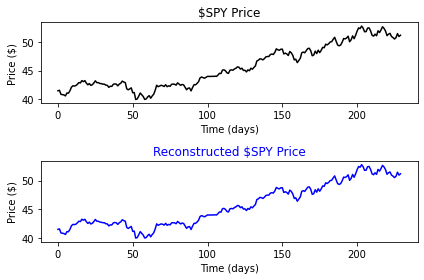

In [7]:
fft = scipy.fft.fft(train_y)
y_reconstructed = scipy.fft.ifft(fft)

print(f"Root Mean Squared Error: {rmse(train_y, np.abs(y_reconstructed))}")
plt.subplot(2, 1, 1)
plt.plot(train_y, c="black")
plt.title('$SPY Price')
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')

plt.subplot(2, 1, 2)
plt.plot(y_reconstructed, c="blue")
plt.title('Reconstructed $SPY Price', color="blue")
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')

plt.tight_layout()
plt.show()

Once again, the extremely small error (1.3e-14) shows that the reconstructed signal is a near-perfect match for the original.

Now, we will predict future prices using the same iDFT methodology as before. 

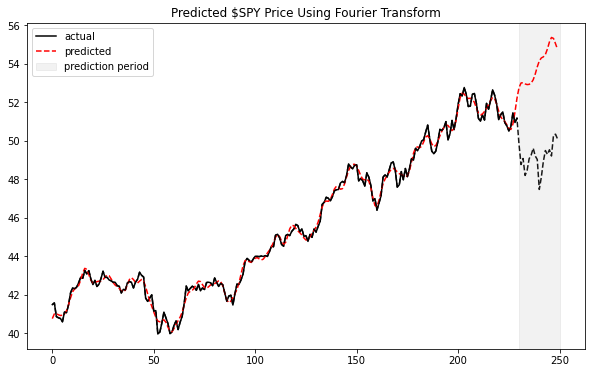

In [8]:
yhat = extrapolate_fourier(train_y, num_steps=test_y.size, num_harmonics=20)

plt.figure(figsize=(10,6))
plt.plot(train_y, c="black", label="actual")
plt.plot(yhat, linestyle="--", c="red", alpha=1.0, label="predicted")

y_all = np.concatenate([train_y, test_y])
plt.plot(y_all, c="black", linestyle="--", alpha=0.9)
plt.axvspan(y_all.size-test_y.size, y_all.size, alpha=0.1, color="gray", label="prediction period")
plt.legend()
plt.title("Predicted $SPY Price Using Fourier Transform")
plt.show()


At first glance, you should notice two things. First, the iDFT was able to model the training data excellently. This isn't surprising, though, as we already know that we can use these methods to interpolate any signal. What is surprising, however, is the degree to which the iDFT model was able to predict our future price values.

Beware, as this is just an illusion. In reality, the iDFT cannot effectively forecast future values. There are several reasons for this, which we will now briefly discuss.

For starters, the iDFT assumes the underlying function will have a period equal to N (which is the number of samples). Likewise, since a signal's frequency is inversely proportional to its period, this means the frequencies are frozen. Consequently, the iDFT cannot effectively model any non-periodic components of a signal. So the fact that it near-perfectly fits the training data is non-consequential for extrapolation. In fact, because the iDFT cannot model non-periodic components, any forecast using this technique will essentially just repeat the patterns identified in the training data forever. This is obviously not ideal.

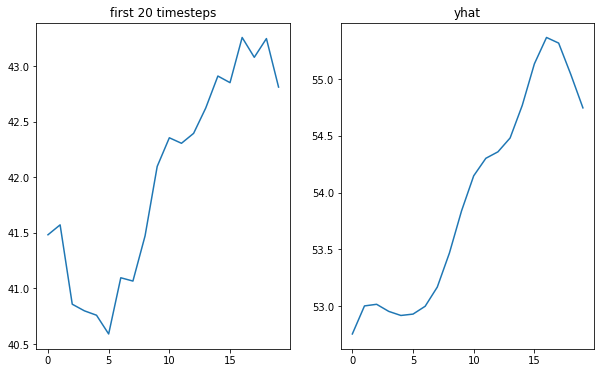

In [9]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(train_y[:test_y.size])
plt.title(f"first {test_y.size} timesteps")
plt.subplot(122)
plt.plot(yhat[-test_y.size:])
plt.title(f"yhat")
plt.show()


To state the obvious, the 20-period "forecast" (titled yhat) is actually just a crude replication of the first 20 timesteps of the series. What's rather amusing, though, is how often this leads to decent results. I have several guesses as to why this is.

For starters, when prices are trending, there is a high likelihood that mimicking the shape of earlier timesteps will be directionally-accurate. Furthermore, prices do seem to have some periodicity. It is important to note, however, that in my experiments this degree of periodicity fluctuated over time, alongside a continuously changing market environment. But, in those relatively periodic market environments, the iDFT's forecast seemed capable of capturing where in time local extrema were located. And given the sinusoidal nature of any iDFT model, this is an important observation, as it gives some credence to the idea that price is indeed a waveform.

Nonetheless, using the iDFT to forecast price movements is a terrible idea by itself, and I definitely am not claiming that it can be used as a winning trading strategy. What I am emphasizing, however, is that there are some interesting characteristics given by iDFT forecasts that may give some insight into the true nature of price movements.

At this point I would like to pause for a brief second and point out that the DFT is technically a simple single-layer neural network with no activation function or bias, and with weights that are pre-calculated. In fact, any linear transformation can be represented this way, as we can rewrite such a transformation using matrix multiplication - which is the basis for neural networks. To conceptualize this, I encourage you to read this blog post (https://sidsite.com/posts/fourier-nets/). 



## Neural Decomposition

This brings us to Neural Decomposition, which is a neural network approach heavily influenced by the iDFT. As you will see, this method mimics the iDFT for modeling periodic components, while also accounting for non-periodicity by using an augmentation function.

Neural Decomposition (ND), detailed in this paper (https://arxiv.org/pdf/1705.09137.pdf), uses an iDFT-like model with two key differences. First, ND allows frequencies to be trained; and second, ND is capable of handling non-periodic components via an augmentation function, referred to as g(t).
Below is the anatomy of this model.


Below is the anatomy of our model.

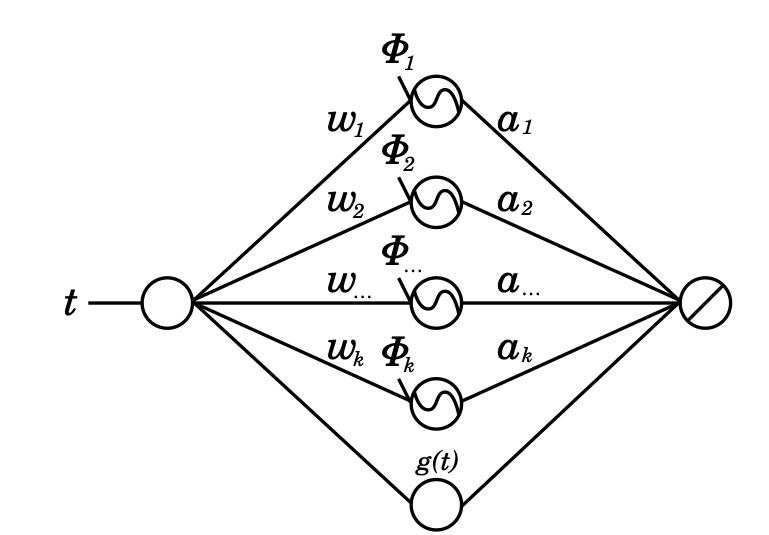


In the diagram above, w(i) represents our frequencies, φ(i) represents our phase-shifts, a(i) represents our amplitudes, and g(t) represents our augmentation function. 

Mathamatically, the model can be described as the below:

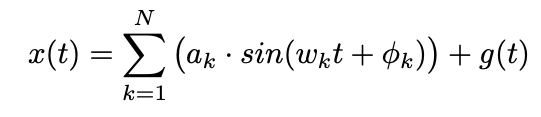


In short, this neural network is an augmented version of the iDFT. Implementing this model architecture is pretty straightforward. 

The model has two layers of size 1 -> m and m -> 1. Here, m represents N plus all the nodes used in g(t), which can be an arbitrary amount. The first N nodes in the hidden layer have a sinusoidal activation function, while the rest of the nodes used by g(t) have a mix of linear and non-linear activation functions. The linear units in g(t) should model trend, while the non-linear units should model any non-periodic components -- something the iDFT alone cannot do.

The weights in our hidden layer associated with our N sinusoidal units are initialized to mimic the iDFT. Each unit has a weight w(k) and bias φ(k), where the weights represent frequencies and the biases represent phase shifts. The weights are initialized to 2π⌊k/2⌋. For each even-indexed unit, we set the bias to π/2 and for each odd-indexed unit, we set it to π. 

For our augmentation function g(t), the weights are randomly perturbed from 1 and the biases are randomly perturbed near 0. We set the weights and biases in this manner in an effort to approximate an identity function. 

All units in the hidden layer are used to produce our output layer, which is just a singular unit. The weights feeding into our singular output unit are set to small random values.

It is important to note that we use L1 regularization on our output layer to promote sparsity. No regularization is applied to the hidden layer so that the network is able to adjust the pre-calculated frequencies only if it required to do so. 

Lets now see the results of this.


In [10]:
class ND(nn.Module):
    """
    **************
    Neural Decomposition (ND) using Fourier Transforms
    **************
    > ND is based on the inverse Discrete Fourier Transform (iDFT), except the frequencies and phase shifts are 
        trainable. A linear unit g(t) -- called the augmentation function in the paper -- is used to model 
        non-periodic components, something the iDFT cannot do, as the frequencies are frozen.
    > ND initializes its weights to mimic the iDFT, and then these weights are fine-tuned during the training process.
    > To simplify, ND is calcualted via the sum of the sine of frequencies and phase-shifts (instead of sum of N/2 sins and N/2 cosine).
    > 1/N is absorbed by preprocessing for our inputs (by dividing X/N). 
    **************
    > Reference Paper: 
        https://arxiv.org/pdf/1705.09137.pdf
    **************
    *   PARAMS   *
    **************
        1. 'n' -> the length of the sequence
        2. 'linear_units' -> number of output units for each layer making up g(t)
        3. 'num_outputs' -> number of outputs of entire model 
                            NOTE: only built to handle 1 for now; which is default
        4. 'noise' -> Amount of noise to add to g(t) weights
    **************
    *  TOPOLOGY  *
    **************
    For an input of size N, the network is initialized with two layers:
        a. 1 -> m
        b. m -> 1
    where m = N + |g(t)| 
    and |g(t)| denotes the number of nodes required by g(t)
    ***************
    * ACTIVATIONS *
    ***************
    The first N nodes in the hidden layer have a sin(t) activation
    The nodes associated with g(t) can have any combination of activation functions
        a. Linear to measure trend
        b. Sigmoidal to measure non-periodic portions
    ***************
    * WEIGHT INIT *
    ***************
    Each of the N sinusoid nodes in the hidden layer (indexed 0 <= K < N), have a frequency w(k) and phase shift b(k)
    1. Each w(k) set to 2π⌊k/2⌋
    
    2. For each even value of k, b(k) set to π/2
        - This transforms sin(t + b(k)) to cos(t)
        
    3. For each odd value of k, b(k) set to π
        - This transforms sin(t + b(k)) to −sin(t)

    4. Weights in hidden layer associated with g(t) are initialzied to approximate identity
        y = w(t) + b
        > w randomly perturbed from 1
        > b randomly perturbed from 0
            
    5. All weights feeding into the output layer are set to small random values
    **************
    """
    def __init__(self, 
                 n: int, 
                 linear_units: int, 
                 noise: float = 0.001):
        super(ND, self).__init__()

        self.wave = nn.Linear(1, n)
        self.unit_linear = nn.Linear(1, linear_units) #g(t) models trend
        self.unit_lrelu = nn.Linear(1, linear_units) #g(t) models non-periodic componenets
        self.unit_sigmoid = nn.Linear(1, linear_units) #g(t) models non-periodic componenets
        
        self.lrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.fc = nn.Linear(n + 3*linear_units, 1) #m -> 1

        params = dict(self.named_parameters())
        #weights represent a frequency
        params['wave.weight'].data = torch.from_numpy((2*np.pi*np.floor(np.arange(n)/2))[:,np.newaxis]).float()
        #bias is phase shift
        params['wave.bias'].data = torch.from_numpy(np.pi/2+np.arange(n)%2*np.pi/2).float()
        
        params['unit_linear.weight'].data = torch.from_numpy(np.ones(shape=(linear_units,1)) + np.random.normal(size=(linear_units,1))*noise).float()
        params['unit_linear.bias'].data = torch.from_numpy(np.random.normal(size=(linear_units))*noise).float()
        
        params['unit_lrelu.weight'].data = torch.from_numpy(np.random.normal(size=(linear_units,1))*noise).float()
        params['unit_lrelu.bias'].data = torch.from_numpy(np.random.normal(size=(linear_units))*noise).float()
        
        params['unit_sigmoid.weight'].data = torch.from_numpy(np.random.normal(size=(linear_units,1))*noise).float()
        params['unit_sigmoid.bias'].data = torch.from_numpy(np.random.normal(size=(linear_units))*noise).float()
        
        params['fc.weight'].data = torch.from_numpy(np.random.normal(size=(1,n+3*linear_units))*noise).float()
        params['fc.bias'].data = torch.from_numpy(np.random.normal(size=(1))*noise).float()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        sinusoid = torch.sin(self.wave(X)) #sine activation
        linear = self.unit_linear(X)
        lrelu = self.lrelu(self.unit_lrelu(X))
        sigmoid = self.sigmoid(self.unit_sigmoid(X))
        combined = torch.cat([sinusoid, linear, lrelu, sigmoid], dim=1)
        out = self.fc(combined)
        return out
    
    
    def fit(self, 
            X: torch.Tensor, 
            y: torch.Tensor,
            num_epochs: int,
            lr: float, 
            l1_reg: float,
            print_every: int = 1000):
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(nd.parameters(), lr=lr)  
        for epoch in range(1, num_epochs+1):
            optimizer.zero_grad() 
            yhat = self(X)
            loss = criterion(yhat, y)
            loss += l1_reg*torch.sum(torch.abs(dict(self.named_parameters())['fc.weight']))
            loss.backward()
            optimizer.step()
            if print_every != -1 and epoch % print_every == 0:
                print (f"Epoch {epoch}, Loss: {loss.item():.4f}")
        
    def predict(self, 
                X: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            return self(X)
        


In [11]:
window = 150
train_y, test_y = prices.sample_split(num_timesteps=window, split_perc=0.15)
y = np.concatenate([train_y, test_y])

pred_period = test_y.size
N = train_y.size

print(f"Train shape: {train_y.shape} || Test shape: {test_y.shape}")


Train shape: (128,) || Test shape: (22,)


In [12]:
#extrapolate using iDFT for a baseline--
fourier_extrap_yhat = extrapolate_fourier(train_y, num_steps=pred_period, num_harmonics=20)
#-----------------------------

train_X = (np.arange(N) / N).reshape(-1,1) #perform the 1/N step for calculating the iDFT

#linear regression baseline---
lr = LinearRegression()
lr.fit(train_X, train_y)
#-----------------------------

#scale y between 0-5, paper suggests 0-10
scaler = MinMaxScaler(feature_range=(0, 5))
train_y = scaler.fit_transform(train_y.reshape(-1,1))

test_X = (np.arange(window) / N).reshape(-1,1)

train_X = torch.from_numpy(train_X).float()
train_X.requires_grad = True

train_y = torch.from_numpy(train_y).float()
train_y.requires_grad = True

nd = ND(n=N, linear_units=1)
nd


ND(
  (wave): Linear(in_features=1, out_features=128, bias=True)
  (unit_linear): Linear(in_features=1, out_features=1, bias=True)
  (unit_lrelu): Linear(in_features=1, out_features=1, bias=True)
  (unit_sigmoid): Linear(in_features=1, out_features=1, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=131, out_features=1, bias=True)
)

In [13]:
#note that paper used learning rate of 1e-2, but we'll use 1e-3
nd.fit(X=train_X, y=train_y, num_epochs=3000, lr=1e-3, l1_reg=0.05, print_every=1000)


Epoch 1000, Loss: 0.3924
Epoch 2000, Loss: 0.3713
Epoch 3000, Loss: 0.3555


In [14]:
yhat = nd.predict(torch.from_numpy(test_X).float()).numpy()
yhat = scaler.inverse_transform(yhat).flatten() 

train_y = scaler.inverse_transform(train_y.detach().numpy()).flatten()

Train Mean Abs Perc Error: 0.21%
Test Mean Abs Perc Error: 3.39%


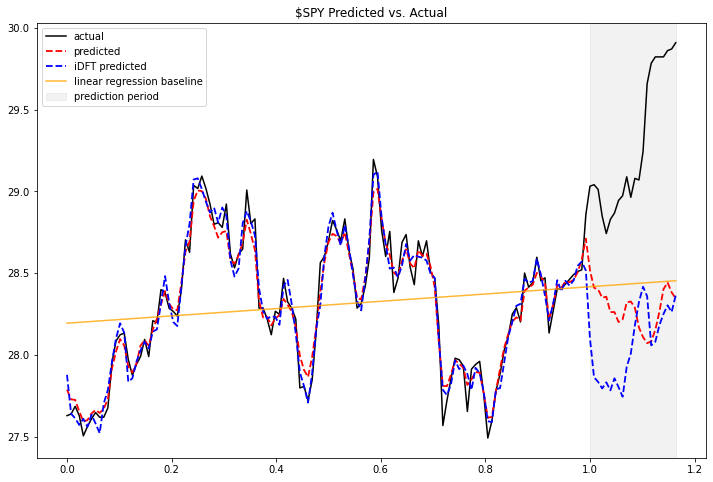

In [15]:
train_error = mean_absolute_percentage_error(train_y, yhat[:-pred_period])
test_error = mean_absolute_percentage_error(test_y, yhat[-pred_period:])

print(f"Train Mean Abs Perc Error: {train_error*100:.2f}%")
print(f"Test Mean Abs Perc Error: {test_error*100:.2f}%")

lr_baseline = lr.predict(test_X)

plt.figure(figsize=(12,8))
plt.plot(test_X.flatten(), y, c="black", label="actual")
plt.plot(test_X.flatten(), yhat, c="red", linestyle="--", label="predicted", linewidth=1.8)
plt.plot(test_X.flatten(), fourier_extrap_yhat, linestyle="--", c="blue", label="iDFT predicted", linewidth=1.8)
plt.plot(test_X.flatten(), lr_baseline, color="orange", alpha=0.8, label="linear regression baseline")
plt.axvspan(1.0, np.max(test_X), alpha=0.1, color="gray", label="prediction period")
plt.legend()
plt.title("$SPY Predicted vs. Actual")
plt.show()

